In [ ]:
# BG-NBD ve Gamma-Gamma ile CLTV Prediction

In [1]:
import datetime as dt
import pandas as pd 
import matplotlib.pyplot as plt 

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#outlier_thresolds | replace_with_thresolds 

In [2]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    

In [ ]:
#Reading Data 

In [ ]:
#df_ = pd.read_excel("datasets/online_retail_II.xlsx", sheet_name="Year 2009-2010")

In [3]:
df_ = pd.read_excel(r'C:\Users\seldabayman\OneDrive\Desktop\online_retail_II.xlsx')
df_.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom


In [ ]:
#Filtered InvoiceDate from 2009 to 2010 

In [5]:
# Start & End Date
start_date = "2009-01-01"
end_date = "2010-12-31"

# Datetime Format
df_['InvoiceDate'] = pd.to_datetime(df_['InvoiceDate'])

# 2009-2010 year filters
df_ = df_[(df_['InvoiceDate'] >= start_date) & (df_['InvoiceDate'] <= end_date)]

print(df_.head())

  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00 6.9500   13085.0000  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00 6.7500   13085.0000  United Kingdom
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00 6.7500   13085.0000  United Kingdom
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00 2.1000   13085.0000  United Kingdom
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24 2009-12-01 07:45:00 1.2500   13085.0000  United Kingdom


In [6]:
df = df_.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [8]:
df.shape

(525461, 8)

In [9]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country'], dtype='object')

In [10]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,525461.0000,10.3377,-9600.0000,1.0000,3.0000,10.0000,19152.0000,107.4241
InvoiceDate,525461,2010-06-28 11:37:36.845017856,2009-12-01 07:45:00,2010-03-21 12:20:00,2010-07-06 09:51:00,2010-10-15 12:45:00,2010-12-09 20:01:00,NaN
Price,525461.0000,4.6888,-53594.3600,1.2500,2.1000,4.2100,25111.0900,146.1269
Customer ID,417534.0000,15360.6455,12346.0000,13983.0000,15311.0000,16799.0000,18287.0000,1680.8113


In [11]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [ ]:
# Manupulating Data 

In [12]:
df.dropna(inplace=True)
df = df[~ df['Invoice'].str.contains('C',na=False)]
df = df[df['Quantity'] > 0 ]
df = df[df['Price'] > 0]

replace_with_thresholds(df,'Quantity')
replace_with_thresholds(df,'Price')

df['TotalPrice']= df['Price'] * df['Quantity']

today_date= dt.datetime(2011,12,11)

In [ ]:
#Preparing Customer Lifetime Data 
# recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)
# T: Customer Age. Weekly. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
# frequency: tekrar eden toplam satın alma sayısı (frequency >1)
# monetary: satın alma başına ortalama kazanç

#Recency:
#The time elapsed since the last purchase, measured in weeks (calculated for each customer individually).
#(Example: If a customer made their last purchase 3 weeks ago, their recency would be 3.)

#T (Customer Age):
#The total time since a customer's first purchase, measured in weeks (calculated relative to the analysis date).
#(Example: If the first purchase of a customer was made 52 weeks ago, their T would be 52.)

#Frequency:
#The total number of repeat purchases by the customer. Only customers with more than one purchase (frequency > 1) are considered.
#(Example: If a customer has made 5 purchases in total, their frequency would be 4 because the first purchase is excluded.)

#Monetary (Average Revenue Per Purchase):
#The average profit or revenue earned per purchase by the customer.
#(Formula: monetary = total revenue / total purchases.)

In [24]:
cltv_df = df.groupby('Customer ID').agg({
                                   'InvoiceDate': [lambda x: (x.max() - x.min()).days,  # Recency
                                                  lambda x: (today_date - x.min()).days  # Age (T)
                                                  ],
                                   'Invoice': lambda x: x.nunique(),  # Frequency
                                   'TotalPrice': lambda x: x.sum()  # Monetary
})

cltv_df.columns= cltv_df.columns.droplevel(0)

cltv_df.columns= ['recency','T', 'frequency', 'monetary']

cltv_df['monetary']= cltv_df['monetary'] /cltv_df['frequency']

cltv_df.describe().T

cltv_df = cltv_df[cltv_df['frequency'] > 1]

cltv_df['recency']= cltv_df['recency'] / 7 

cltv_df['T']= cltv_df['T'] / 7


In [25]:
cltv_df

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,28.0000,103.7143,11,33.8964
12347.0000,5.2857,57.8571,2,661.6600
12349.0000,25.8571,84.2857,3,765.0067
12352.0000,2.2857,56.1429,2,171.9000
12356.0000,6.2857,60.7143,3,1187.4167
...,...,...,...,...
18276.0000,48.0000,104.2857,5,264.1320
18277.0000,13.8571,70.7143,4,256.6650
18283.0000,39.2857,94.1429,6,106.9617


In [ ]:
#BG-NBD Modelling and Fitting 

In [33]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])


bgf.predict(
    t=1,
    frequency=cltv_df['frequency'].sort_values(ascending=False).head(10),  # Top 10 customer
    recency=cltv_df['recency'].sort_values(ascending=False).head(10),
    T=cltv_df['T'].sort_values(ascending=False).head(10)
)

# All customers predict
cltv_df["expected_purc_1_week"] = bgf.predict(
    t=1,
    frequency=cltv_df['frequency'],
    recency=cltv_df['recency'],
    T=cltv_df['T']
)

In [34]:
cltv_df["expected_purc_1_week"]

Customer ID
12346.0000   0.0000
12347.0000   0.0004
12349.0000   0.0014
12352.0000   0.0002
12356.0000   0.0001
              ...  
18276.0000   0.0023
18277.0000   0.0002
18283.0000   0.0009
18286.0000   0.0026
18287.0000   0.0010
Name: expected_purc_1_week, Length: 2893, dtype: float64

In [ ]:
# 1 ay içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
#"Who are the top 10 customers expected to make the most purchases within the next month?"

In [35]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

11.608238398752194

In [36]:
cltv_df["expected_purc_1_month"]

Customer ID
12346.0000   0.0000
12347.0000   0.0015
12349.0000   0.0056
12352.0000   0.0007
12356.0000   0.0005
              ...  
18276.0000   0.0092
18277.0000   0.0007
18283.0000   0.0036
18286.0000   0.0103
18287.0000   0.0041
Name: expected_purc_1_month, Length: 2893, dtype: float64

In [ ]:
# 3 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?
#What is the total number of expected sales for the entire company over the next 3 months?

In [38]:
bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])
cltv_df["expected_purc_3_month"]

Customer ID
12346.0000   0.0000
12347.0000   0.0043
12349.0000   0.0160
12352.0000   0.0019
12356.0000   0.0014
              ...  
18276.0000   0.0265
18277.0000   0.0019
18283.0000   0.0104
18286.0000   0.0300
18287.0000   0.0117
Name: expected_purc_3_month, Length: 2893, dtype: float64

In [ ]:
#Predict plot

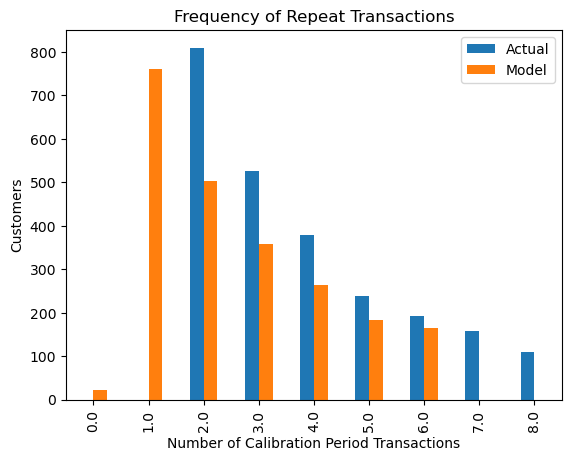

In [39]:
plot_period_transactions(bgf)
plt.show()

In [ ]:
#Gamma Gamma (ggf) Modelling (frequency , monetary, avg.profit)

In [40]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)


,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12357.0000,0.0000,55.5714,2,5633.4650,0.0001,0.0003,0.0008,6172.3459
17450.0000,10.0000,62.7143,7,5321.5850,0.0000,0.0000,0.0000,5457.7883
14091.0000,6.2857,99.8571,2,4584.0450,0.0000,0.0002,0.0005,5022.9216
14088.0000,2.0000,60.2857,3,4512.9900,0.0000,0.0001,0.0003,4792.1915
18102.0000,53.2857,105.5714,89,3526.4424,0.0000,0.0000,0.0000,3533.3926
12409.0000,20.5714,80.8571,4,3086.6550,0.0003,0.0014,0.0039,3228.0113
14646.0000,51.7143,105.4286,78,3108.7672,0.0000,0.0000,0.0000,3115.7658
12454.0000,3.5714,60.2857,4,2811.4450,0.0000,0.0000,0.0001,2940.2847
16684.0000,50.2857,104.7143,27,2847.7670,0.0000,0.0000,0.0000,2866.3781


In [ ]:
# 4. BG-NBD ve GG Model- Calculated CLTV 

In [44]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 months
                                   freq="W",  # T frequency
                                   discount_rate=0.01)

cltv.head()

Customer ID
12346.0000    0.0002
12347.0000    3.2751
12349.0000   13.7464
12352.0000    0.3763
12356.0000    1.9081
Name: clv, dtype: float64

In [ ]:
#reset_index, merge and sort

In [45]:
cltv = cltv.reset_index()

cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)


,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
67,12497.0000,34.8571,92.1429,2,2563.8200,0.0042,0.0166,0.0480,2810.1798,142.8872
1671,15823.0000,51.1429,104.5714,3,1292.0500,0.0062,0.0245,0.0709,1372.9255,103.1798
83,12557.0000,50.1429,103.2857,4,1681.2950,0.0046,0.0180,0.0520,1758.7351,96.9996
1059,14564.0000,42.8571,105.1429,2,1302.8100,0.0044,0.0175,0.0508,1429.0021,76.9371
6,12358.0000,50.8571,104.5714,3,901.2367,0.0061,0.0240,0.0694,958.0482,70.4795
449,13373.0000,45.2857,104.8571,3,1424.9800,0.0038,0.0150,0.0435,1514.0405,69.8940
58,12477.0000,31.8571,89.1429,3,2352.2100,0.0023,0.0090,0.0260,2498.3637,68.8879
2127,16732.0000,46.8571,104.5714,3,1175.2767,0.0044,0.0175,0.0505,1248.9619,66.8987
42,12435.0000,48.5714,105.4286,4,1460.2225,0.0035,0.0136,0.0393,1527.6081,63.6585
221,12873.0000,40.5714,97.4286,2,826.6500,0.0052,0.0205,0.0595,907.4665,57.2302


In [ ]:
#Segmentation for CLTV

In [46]:
cltv_final

cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

cltv_final.sort_values(by="clv", ascending=False).head(50)

cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})

Customer ID                          recency                        T                    frequency               monetary                      expected_purc_1_week               expected_purc_1_month               expected_purc_3_month                expected_average_profit                        clv                   
              count           sum       mean   count        sum    mean count        sum    mean     count   sum    mean    count         sum     mean                count    sum   mean                 count    sum   mean                 count     sum   mean                   count         sum     mean count        sum    mean
segment                                                                                                                                                                                                                                                                                                                                 
D               724 11226870.0000 15506.7265     724 16447.1429 22.7170   724 63682.5714 87.9594       724  8403 11.6064      724 236682.9841 326.9102                  724 0.0252 0.0000                   724 0.0991 0.0001                   724  0.2832 0.0004                     724 244735.4256 338.0324   724    59.2836  0.0819
C               723 11080156.0000 15325.2503     723 16888.7143 23.3592   723 61453.0000 84.9972       723  3681  5.0913      723 241095.7126 333.4657                  723 0.1993 0.0003                   723 0.7830 0.0011                   723  2.2435 0.0031                     723 254348.7239 351.7963   723   572.9409  0.7924
B               723 11097464.0000 15349.1895     723 21845.1429 30.2146   723 64960.4286 89.8484       723  3195  4.4191      723 266124.8549 368.0842                  723 0.6958 0.0010                   723 2.7373 0.0038                   723  7.8671 0.0109                     723 281376.0014 389.1784   723  2264.3624  3.1319
A               723 11005511.0000 15222.0069     723 27362.1429 37.8453   723 68931.4286 95.3408       723  2515  3.4786      723 338615.1853 468.3474                  723 2.0273 0.0028                   723 7.9888 0.0110                   723 23.0563 0.0319                     723 360241.1576 498.2589   723 10412.1718 14.4013

In [ ]:
#Functionalized Code

In [47]:
def create_cltv_p(dataframe, month=3):
    # 1. Data Process
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7

    # 2. BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    # 3. GAMMA-GAMMA Model
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # 4. BG-NBD ve GG Model- CLTV
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=month,  # 3 months
                                       freq="W",  # T frequency
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

    return cltv_final


In [ ]:
df = df_.copy()

cltv_final2 = create_cltv_p(df)

cltv_final2.to_csv("cltv_prediction.csv")

In [48]:
cltv_final2

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,12346.0000,28.0000,103.7143,11,33.8964,0.0000,0.0000,0.0000,34.7855,0.0002,D
1,12347.0000,5.2857,57.8571,2,661.6600,0.0004,0.0015,0.0043,726.7538,3.2751,B
2,12349.0000,25.8571,84.2857,3,765.0067,0.0014,0.0056,0.0160,813.4300,13.7464,A
3,12352.0000,2.2857,56.1429,2,171.9000,0.0002,0.0007,0.0019,190.3223,0.3763,C
4,12356.0000,6.2857,60.7143,3,1187.4167,0.0001,0.0005,0.0014,1261.8495,1.9081,B
...,...,...,...,...,...,...,...,...,...,...,...
2888,18276.0000,48.0000,104.2857,5,264.1320,0.0023,0.0092,0.0265,274.4279,7.6970,A
2889,18277.0000,13.8571,70.7143,4,256.6650,0.0002,0.0007,0.0019,269.3124,0.5392,C
2890,18283.0000,39.2857,94.1429,6,106.9617,0.0009,0.0036,0.0104,110.7961,1.2207,C
2891,18286.0000,35.2857,103.4286,2,641.6850,0.0026,0.0103,0.0300,704.8753,22.4203,A
